# Operator Overloading (2)

## Rich comparison operators
기존에 보았던 연산자 오버로딩과 다음 두가지 측면에서 차이가 있다.  
1. 정방향 연산자와 역방향 역산자를 호출할 때, 같은 메소드 집합이 사용된다. 예를 들어, `==`의 경우 정방향 호출, 역방향 호출 모두 `__eq__` 메소드를 호출한다. (인자는 바뀐다.) `>`의 경우, 정방향 연산으로 `__gt__`가 호출되고, 역방향 연산으로 `__lt__` 메소드가 호출된다. 
2. `==`와 `!=`의 경우, 역방향 호출이 실패하면 `TypeError`를 반환하는 대신 객체의 ID를 비교하여 결과를 반환한다. 

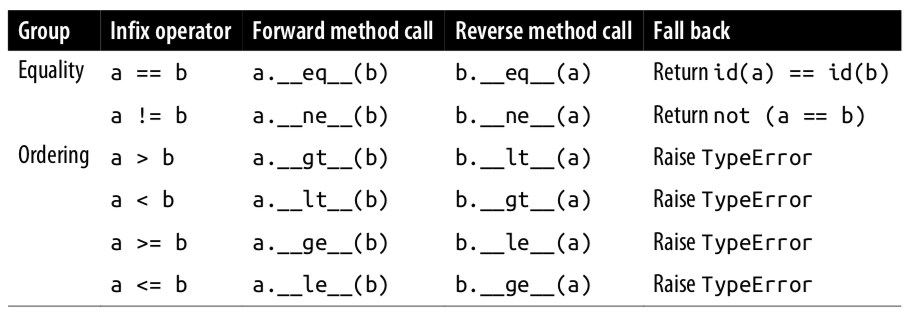

cf) 비교 연산자의 fallback 과정은 Python2와 Python3가 차이가 있다.  
1. Python2에서 `==`의 부정은 `!=`이 아니었다. 따라서 `==`를 정의할 때, `!=`도 함께 정의해줘야한다. 하지만 Python3에서는 내부적으로 `object` 클래스에 `__ne__` 메소드가 잘 구현되어있어서 따로 override해서 사용할 필요가 거의 없다.  
```
def __ne__(self, other):
    eq_result = self == other
    if eq_result is NotImplemented:
        return NotImplemented
    else:
        return not eq_result
```
2. `<`, `>`와 같은 ordering 비교 연산자의 경우, int와 tuple처럼 비교가 서로 불가능한 피연산자를 넣었을 때, Python3에서는 `TypeError`를 반환하지만 Python2에서는 객체의 type과 id를 고려하여 이상한 결과를 반환할 수 있다. 

In [10]:
from array import array
import reprlib
import math
import numbers
import functools
import operator
import itertools

class Vector:
    typecode = 'd'

    def __init__(self, components):
        self._components = array(self.typecode, components) 
    
    def __iter__(self):
        return iter(self._components)

    def __repr__(self):
        components = reprlib.repr(self._components) 
        components = components[components.find('['):-1] 
        return 'Vector({})'.format(components)

    def __str__(self):
        return str(tuple(self))

    def __bytes__(self):
        return (bytes([ord(self.typecode)]) +
                bytes(self._components))

    def __eq__(self, other):
        return (len(self) == len(other) and
                all(a == b for a, b in zip(self, other)))

    def __hash__(self):
        hashes = (hash(x) for x in self)
        return functools.reduce(operator.xor, hashes, 0)

    def __abs__(self):
        return math.sqrt(sum(x * x for x in self))

    def __bool__(self): 
        return bool(abs(self))

    def __len__(self):
        return len(self._components)

    def __getitem__(self, index): 
        cls = type(self)
        if isinstance(index, slice):
            return cls(self._components[index])
        elif isinstance(index, numbers.Integral): 
            return self._components[index]
        else:
            msg = '{.__name__} indices must be integers' 
            raise TypeError(msg.format(cls))
    
    shortcut_names = 'xyzt'
    
    def __getattr__(self, name): 
        cls = type(self)
        if len(name) == 1:
            pos = cls.shortcut_names.find(name) 
            if 0 <= pos < len(self._components):
                return self._components[pos]
        msg = '{.__name__!r} object has no attribute {!r}' 
        raise AttributeError(msg.format(cls, name))

    def angle(self, n):
        r = math.sqrt(sum(x * x for x in self[n:])) 
        a = math.atan2(r, self[n-1])
        if (n == len(self) - 1) and (self[-1] < 0):
            return math.pi * 2 - a 
        else:
            return a 
    
    def angles(self):
        return (self.angle(n) for n in range(1, len(self)))

    def __format__(self, fmt_spec=''):
        if fmt_spec.endswith('h'): # hyperspherical coordinates
            fmt_spec = fmt_spec[:-1]
            coords = itertools.chain([abs(self)],
                                     self.angles())
            outer_fmt = '<{}>' 
        else:
            coords = self
            outer_fmt = '({})'
        components = (format(c, fmt_spec) for c in coords) 
        return outer_fmt.format(', '.join(components))

    @classmethod
    def frombytes(cls, octets):
        typecode = chr(octets[0])
        memv = memoryview(octets[1:]).cast(typecode) 
        return cls(memv)

In [14]:
from array import array 
import math

class Vector2d: 
    typecode = 'd'

    def __init__(self, x, y): 
        self.__x = float(x) 
        self.__y = float(y)

    @property
    def x(self): 
        return self.__x

    @property
    def y(self): 
        return self.__y

    def __iter__(self):
        return (i for i in (self.x, self.y))

    def __repr__(self):
        class_name = type(self).__name__
        return '{}({!r}, {!r})'.format(class_name, *self)

    def __str__(self):
        return str(tuple(self))

    def __bytes__(self):
        return (bytes([ord(self.typecode)]) +
                bytes(array(self.typecode, self)))

    def __eq__(self, other):
        return tuple(self) == tuple(other)

    def __hash__(self):
        return hash(self.x) ^ hash(self.y)

    def __abs__(self):
        return math.hypot(self.x, self.y)

    def __bool__(self): 
        return bool(abs(self))

    def __len__(self):
        return 2

    def angle(self):
        return math.atan2(self.y, self.x)

    def __format__(self, fmt_spec=''): 
        if fmt_spec.endswith('p'):
            fmt_spec = fmt_spec[:-1]
            coords = (abs(self), self.angle())
            outer_fmt = '<{}, {}>'
        else:
            coords = self
            outer_fmt = '({}, {})'
        components = (format(c, fmt_spec) for c in coords) 
        return outer_fmt.format(*components)
    
    @classmethod
    def frombytes(cls, octets):
        typecode = chr(octets[0])
        memv = memoryview(octets[1:]).cast(typecode) 
        return cls(*memv)

In [15]:
va = Vector([1., 2., 3.])
vb = Vector(range(1,4))
va == vb

True

In [16]:
vc = Vector([1, 2])
v2d = Vector2d(1, 2)
vc == v2d

True

In [17]:
t3 = (1, 2, 3)
va == t3

True

마지막 결과는 바람직한 결과가 아닐 수도 있다. 지나치게 연산을 유연하게 사용하면 예상치 못한 결과가 생길 수도 있기 때문이다. 따라서 피연산자 type 확인 후 연산을 다르게 적용하는 것이 좋다. 

In [40]:
class Vector_eq(Vector):
    def __eq__(self, other):
        if isinstance(other, Vector_eq):
            return (len(self) == len(other) and 
                    all(a == b for a, b in zip(self, other)))
        else:
            return NotImplemented

In [41]:
va2 = Vector_eq([1., 2., 3.])
vb2 = Vector_eq(range(1,4))
va2 == vb2

True

In [42]:
vc2 = Vector_eq([1, 2])
v2d2 = Vector2d(1, 2)
vc2 == v2d2

True

In [43]:
t3 = (1, 2, 3)
va2 == t3

False

## Augmented Assignment Operators (복합 할당 연산자)
Vector 클래스는 이미 `+=`과 `*=` 연산을 지원한다. 해당 연산자에 대한 메소드를 직접 구현하지 않아도 `__add__` 메소드를 가지고 있으면 코드를 추가해주지 않아도 `a += b`가 `a = a + b`와 같은 과정으로 실행된다.  
하지만 `__iadd__`와 같은 메소드(in-place operator method)를 구현하면 `a += b`를 계산할 때 해당 메소드가 호출된다. in-place operator method는 새로운 객체를 생성하지 않고 원래의 결과(좌변)를 바꾼다. 하지만 immutable type에 대해서는 이 메소드를 절대 구현하면 안된다. 

In [26]:
import random

class BingoCage:
    
    def __init__(self, items):
        self._randomizer = random.SystemRandom()
        self._items = []
        self.load(items)
        
    def load(self, items):
        self._items.extend(items)
        self._randomizer.shuffle(self._items)
        
    def pick(self):
        try:
            return self._items.pop()
        except IndexError:
            raise LookupError('pick from empty BingoCage')
            
    def __call__(self):
        self.pick()
    
    def loaded(self):
        return bool(self._items)
    
    def inspect(self):
        return tuple(sorted(self._items))

In [44]:
class AddableBingoCage(BingoCage):
    
    def __add__(self, other):
        if isinstance(other, BingoCage):
            return AddableBingoCage(self.inspect() + other.inspect())
        else:
            return NotImplemented
        
    def __iadd__(self, other):
        if isinstance(other, BingoCage):
            other_iterable = other.inspect()
        else:
            try:
                other_iterable = iter(other)
            except TypeError:
                self_cls = type(self).__name__
                msg = "right operand in += must be {!r} or an iterable"
                raise TypeError(msg.format(self_cls))
        self.load(other_iterable)
        return self

In [45]:
vowels = 'AEIOU'
globe = AddableBingoCage(vowels)
globe.inspect()

('A', 'E', 'I', 'O', 'U')

In [46]:
globe.pick()

'O'

In [47]:
len(globe.inspect())

4

In [32]:
globe2 = AddableBingoCage('XYZ')
globe3 = globe + globe2
len(globe3.inspect())

7

In [33]:
void = globe + [10, 20]

TypeError: unsupported operand type(s) for +: 'AddableBingoCage' and 'list'

일단 `__add__` 메소드와 그 예시들부터 살펴보면, 코드 구현에서 결과값을 반환할 때 생성자를 호출하여 새로운 인스턴스를 생성, 반환한다. 그리고 두 번째 피연산자도 BingoCage 일 때에만 연산이 가능하여, 위의 예시에서 `list`와 연산했을 때 TypeError를 반환하였다. 

In [34]:
globe_orig = globe
len(globe.inspect())

4

In [35]:
globe += globe2
len(globe.inspect())

7

In [36]:
globe += ['M', 'N']
len(globe.inspect())

9

In [37]:
globe is globe_orig

True

In [38]:
globe += 1

TypeError: right operand in += must be 'AddableBingoCage' or an iterable

위의 예시를 그대로 가져와서 복합 할당을 사용해본다. 같은 type인 BingoCage와 연산이 가능한 것은 물론, list 형과도 연산이 가능하다. 그리고 `is` 연산을 통해 확인했을 때, `True`가 반환되었으므로 id 값이 변하지 않고 유지되었음을 확인할 수 있다. (새로운 객체가 생성된 것이 아님)

cf) 두 번째 피연산자에 대한 기준이 복합할당 연산자에 대하여 더 느슨하게 적용된 이유는 결과 값 type에 대한 혼동 여지가 없기 때문이다. 예를 들어 list 연산의 경우, `list + x`에서 x는 꼭 list여야 연산이 가능하지만, `list += x`에서 x는 iterable 객체이면 연산이 가능하다. 

cf) infix operator를 구현할 때, 왼쪽과 오른쪽 피연산자의 타입이 같아야하는 경우는 정방향 연산자(ex. `__mul__`)만 구현하고, 역방향 연산자(ex. `__rmul__`)는 따로 구현하지 않아도 된다. 